# Usage of the codes 

This notebook uses a dataset to present the main function from the class `BivariateBeta` from the `parameter_estimation.py` file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
plt.style.use('science')

import sys
import os
sys.path.append('../scripts/python')

from parameter_estimation import BivariateBeta

Some pre sets:

In [3]:
folder = '../data/covid_tests_data/'
filter_func = lambda i: lambda x: float(re.findall('[0-9].[0-9][0-9]', x.replace(',', '.'))[i])

set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v3-1.stan')
model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

ValueError: No CmdStan directory, path /home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan does not exist.

## The data: Accuracy of diagnostic tests registered by ANVISA for COVID-19

A documentary investigation was carried out utilizing the information provided by manufacturers during their registration with Anvisa. 
The diagnostic tests recorded with Anvisa up to June 23, 2020, during the data collection period, were scrutinized through the use of the following link: [https://consultas.anvisa.gov.br/#/saude/q/?nomeTecnico=coronav%C3%ADrus](https://consultas.anvisa.gov.br/#/saude/q/?nomeTecnico=coronav%C3%ADrus).

The data that was registered with Anvisa during the time of registration was retrieved from the Agency's website, specifically from the General Management of Health Product Technology (GGTPS) for in vitro diagnosis. 
To present the data in a structured format, a standard table created by the authors was employed, gathering essential information such as: i) company/importer; ii) manufacturer/country; iii) sample; iv) whether it was classified as a quick test v) Anvisa registration number; vi) sensitivity/specificity data presented by the manufacturer. 
The information provided by the manufacturers during their registration with Anvisa was then used to generate graphs displaying the sensitivity and specificity of the diagnostic tests.

The data provided by the manufacturers were plotted in the figures presented to illustrate the IgG and/or IgM sensitivity and specificity of the tests:

a) immunochromatographic with blood sample (whole blood, venous whole blood, whole blood via digital puncture or dried blood), human serum or plasma;

b) immunochromatographic with secretion nasopharyngeal swab and oropharyngeal swab;

c) immunoassay with blood sample (whole blood, venous whole blood, whole blood via finger prick or dried blood), human serum or plasma;

d) immunoassay with nasopharyngeal swab and oropharyngeal swab secretion sample;

e) qualitative or semi-qualitative detection with blood sample

In [25]:
tables = [pd.read_csv(folder+'raw/table_a.csv'),
          pd.read_csv(folder+'raw/table_b.csv'),
          pd.read_csv(folder+'raw/table_c.csv'),
          pd.read_csv(folder+'raw/table_d.csv'),
          pd.read_csv(folder+'raw/table_e.csv'),
          pd.read_csv(folder+'raw/table_pcr_a.csv'),
          pd.read_csv(folder+'raw/table_pcr_b.csv'),
          pd.read_csv(folder+'raw/table_pcr_c.csv'),
         ]

letters = ['a', 'b', 'c', 'd', 'e', 'a_pcr', 'b_pcr', 'c_pcr']
for i in range(8):

    tables[i]['sensitivity']          = tables[i]['Sensitivity [95% CI]'].apply(filter_func(0))
    tables[i]['sensitivity_ci_lower'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(1))
    tables[i]['sensitivity_ci_upper'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(2))
    tables[i]['specificity']          = tables[i]['Specificity [95% CI]'].apply(filter_func(0))
    tables[i]['specificity_ci_lower'] = tables[i]['Specificity [95% CI]'].apply(filter_func(1))
    tables[i]['specificity_ci_upper'] = tables[i]['Specificity [95% CI]'].apply(filter_func(2))
    tables[i]['type']                 = letters[i]
    
    del tables[i]['Sensitivity [95% CI]']
    del tables[i]['Specificity [95% CI]']
    
df = pd.concat(tables)

In [26]:
df

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper,type
0,10071770900,312,1,49,234,0.86,0.82,0.90,1.00,0.98,1.00,a
1,10071770901,46,3,2,47,0.96,0.86,0.99,0.94,0.83,0.99,a
2,10210410105,90,3,3,124,0.97,0.91,0.99,0.98,0.93,1.00,a
3,10310030208,171,12,12,514,0.93,0.89,0.97,0.98,0.96,0.99,a
4,10342880015,23,2,1,49,0.96,0.79,1.00,0.96,0.87,1.00,a
...,...,...,...,...,...,...,...,...,...,...,...,...
11,80867150018,209,10,0,370,1.00,0.98,1.00,0.97,0.95,0.99,a_pcr
12,80954880134,3,0,0,98,1.00,0.29,1.00,1.00,0.96,1.00,a_pcr
0,10009010357,60,0,0,60,1.00,0.94,1.00,1.00,0.94,1.00,b_pcr
1,10223400001,10,0,0,14,1.00,0.69,1.00,1.00,0.77,1.00,b_pcr


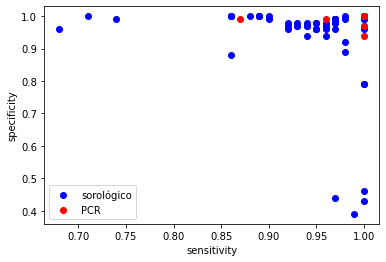

In [4]:
plt.scatter(df[~df.type.str.contains('pcr')].sensitivity, df[~df.type.str.contains('pcr')].specificity,
            color='blue', label='sorológico')
plt.scatter(df[df.type.str.contains('pcr')].sensitivity, df[df.type.str.contains('pcr')].specificity, 
            color='red', label='PCR')
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.legend(loc='lower left')
plt.show()

In [5]:
df.describe()

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper
count,7.100000e+01,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,5.591396e+10,115.394366,13.971831,7.183099,191.676056,0.946901,0.835070,0.976479,0.942958,0.881127,0.962676
std,3.390722e+10,97.261427,45.681810,11.856656,212.390192,0.065500,0.174076,0.037037,0.132432,0.154064,0.113187
min,1.000901e+10,2.000000,0.000000,0.000000,5.000000,0.680000,0.160000,0.820000,0.390000,0.320000,0.440000
25%,1.034136e+10,49.000000,0.500000,0.000000,60.000000,0.930000,0.820000,0.970000,0.960000,0.890000,0.990000
50%,8.025802e+10,92.000000,2.000000,3.000000,124.000000,0.970000,0.890000,0.990000,0.980000,0.930000,1.000000
75%,8.086715e+10,169.000000,9.000000,7.500000,241.000000,1.000000,0.925000,1.000000,1.000000,0.960000,1.000000
max,8.198451e+10,422.000000,297.000000,49.000000,1364.000000,1.000000,0.980000,1.000000,1.000000,0.990000,1.000000


In [6]:
distribution = BivariateBeta()

x = df.specificity
y = df.sensitivity

m1 = np.mean(x)
m2 = np.mean(y)
v1 = np.var(x, ddof=1)
v2 = np.var(y, ddof=1)
rho = np.corrcoef(x, y)[0,1]

moments = [m1, m2, v1, v2, rho]
moments

[0.9429577464788733,
 0.9469014084507043,
 0.017538269617706236,
 0.0042902615694164975,
 -0.18700410861015324]

Estimating through the method of moments:

In [7]:
alpha_hat1 = distribution.method_moments_estimator_1(x, y)

In [8]:
alpha_hat2 = distribution.method_moments_estimator_2(x, y)

In [9]:
alpha_hat3 = distribution.method_moments_estimator_3(x, y, alpha0=(1,1))

In [10]:
alpha_hat4 = distribution.method_moments_estimator_4(x, y, alpha0=(1,1,1,1))

In [38]:
a = 1*np.ones(4)
b = 1*np.ones(4)

data = {'n': len(x), 'a': a, 'b': b, 'xy': np.column_stack([x,y])}

model_fit = model3.sample(data=data, iter_warmup=2000, iter_sampling=2000, chains=4, adapt_delta=0.9)

21:58:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:58:27 - cmdstanpy - ERROR - CmdStan error: error during processing Operation not permitted


21:58:27 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:

Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=1
 cmd (chain 1):
	['/home/lucasmoschen/Documents/github/bivariate-beta/scripts/stan/bivariate-beta-model-v3', 'id=1', 'random', 'seed=35241', 'data', 'file=/tmp/tmp6rnm1eix/9jz_740w.json', 'output', 'file=/tmp/tmp6rnm1eix/bivariate-beta-model-v3zpqzrf5_/bivariate-beta-model-v3-20220930215827.csv', 'method=sample', 'num_samples=2000', 'num_warmup=2000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9', 'num_chains=4']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp6rnm1eix/bivariate-beta-model-v3zpqzrf5_/bivariate-beta-model-v3-20220930215827_1.csv
 console_msgs (if any):
	/tmp/tmp6rnm1eix/bivariate-beta-model-v3zpqzrf5_/bivariate-beta-model-v3-20220930215827-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

In [46]:
distribution.positive_diagnostic_diagnostic(x,y)

-0.006696133857051478